PCA instead of feature selection
single model od adhda and sex f remove and use multiple
remove garphs and just classification report


In [2]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

In [5]:
target = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAINING_SOLUTIONS.xlsx')
categorical = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx')
function = pd.read_csv(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
quantitative = pd.read_excel(r'C:\Users\abdur\vs_code\sidra\widsdatathon2025\TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx')

target.shape, categorical.shape, function.shape,quantitative.shape
len(target['participant_id'].unique()),\
len(categorical['participant_id'].unique()),\
len(function['participant_id'].unique()),\
len(quantitative['participant_id'].unique())

(1213, 1213, 1213, 1213)

In [6]:
def get_feats(mode='TRAIN'):
    # Define base dataset path
    base_path = r'C:\Users\abdur\vs_code\sidra\widsdatathon2025'
    mode_path = os.path.join(base_path, mode)
    
    # Load quantitative metadata
    feats = pd.read_excel(os.path.join(mode_path, f'{mode}_QUANTITATIVE_METADATA.xlsx'), engine='openpyxl')
    
    # Load categorical metadata with correct filename depending on mode
    if mode == 'TRAIN':
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL_METADATA.xlsx')
    else:
        cate_path = os.path.join(mode_path, f'{mode}_CATEGORICAL.xlsx')
    
    cate = pd.read_excel(cate_path, engine='openpyxl')
    
    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')
    
    # Load functional connectome matrices
    func = pd.read_csv(os.path.join(mode_path, f'{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv'))
    feats = feats.merge(func, on='participant_id', how='left')
    
    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution_path = os.path.join(mode_path, 'TRAINING_SOLUTIONS.xlsx')
        solution = pd.read_excel(solution_path, engine='openpyxl')
        feats = feats.merge(solution, on='participant_id', how='left')
    
    return feats
# Load the combined dataset for training
df_train = get_feats('TRAIN')
print("Final dataset shape:", df_train.shape)

Final dataset shape: (1213, 19930)


In [7]:
train_df = get_feats(mode='TRAIN')
test_df = get_feats(mode='TEST')
print (train_df.shape, test_df.shape)
# Display the first few rows of the training data
train_df.head()

(1213, 19930) (304, 19928)


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


In [8]:
test_df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [9]:
# Drop 'participant_id' column
train_df = train_df.drop(columns=['participant_id'])

In [10]:

# Get data types of all columns
print("Data types of columns:")
print(train_df.dtypes)

Data types of columns:
EHQ_EHQ_Total           float64
ColorVision_CV_Score      int64
APQ_P_APQ_P_CP            int64
APQ_P_APQ_P_ID            int64
APQ_P_APQ_P_INV           int64
                         ...   
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
ADHD_Outcome              int64
Sex_F                     int64
Length: 19929, dtype: object


In [11]:
# Take the first 50 rows of train_df
train_df_50 = train_df

In [12]:
# Check for missing values
print("Missing values in each column:")
print(train_df_50.isnull().sum())


Missing values in each column:
EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
ADHD_Outcome            0
Sex_F                   0
Length: 19929, dtype: int64


In [13]:
# Load Data (Ensure train_df_50 is already loaded before running this code)
# Extract labels if they are part of train_df_50
if 'labels' not in globals():
    labels = train_df_50[["ADHD_Outcome", "Sex_F"]].copy()  # Extract labels from train_df_50

# 1. Drop columns
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_df_50 = train_df_50.drop(columns=drop_cols, errors='ignore')  # Avoid errors if column missing

# 2. Remove non-numeric columns before scaling
numeric_cols = train_df_50.select_dtypes(include=[np.number]).columns  # Keep only numeric columns
train_df_50 = train_df_50[numeric_cols]  # Drop categorical or object columns

# 3. Normalize features using MinMaxScaler
scaler = MinMaxScaler()
train_df_50.iloc[:, :] = scaler.fit_transform(train_df_50)


# 5. Retrieve target variables
y_adhd = labels["ADHD_Outcome"].copy()
y_sex = labels["Sex_F"].copy()



In [14]:
print(train_df_50["ADHD_Outcome"].unique())
print(train_df_50["Sex_F"].unique())
print(train_df_50["ADHD_Outcome"].value_counts())
print(train_df_50["Sex_F"].value_counts())

[1 0]
[1 0]
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64
Sex_F
0    797
1    416
Name: count, dtype: int64


ADHD Outcome categories: [1 0]
Sex_F categories: [1 0]

ADHD Outcome distribution:
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

Sex distribution:
Sex_F
0    797
1    416
Name: count, dtype: int64

Missing values in training data:
EHQ_EHQ_Total           0
ColorVision_CV_Score    0
APQ_P_APQ_P_CP          0
APQ_P_APQ_P_ID          0
APQ_P_APQ_P_INV         0
                       ..
197throw_198thcolumn    0
197throw_199thcolumn    0
198throw_199thcolumn    0
ADHD_Outcome            0
Sex_F                   0
Length: 19923, dtype: int64

=== ADHD Outcome Prediction Models ===
Logistic Regression - F1 Score: 0.6091
              precision    recall  f1-score   support

           0       0.57      0.10      0.18        77
           1       0.70      0.96      0.81       166

    accuracy                           0.69       243
   macro avg       0.64      0.53      0.49       243
weighted avg       0.66      0.69      0.61       243

-------------------------------------

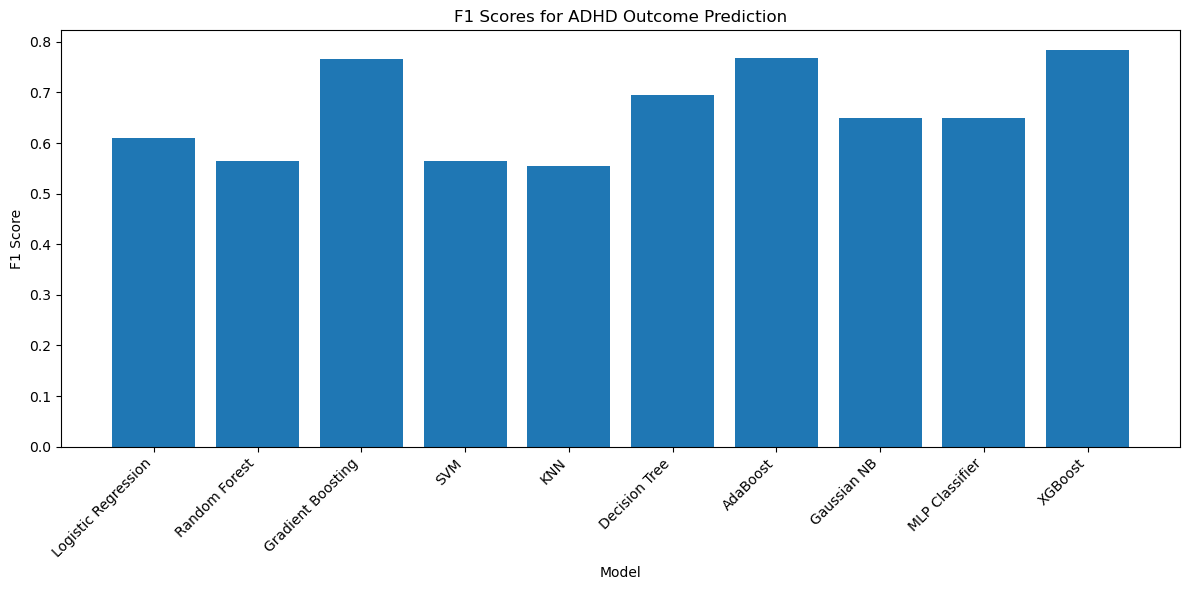

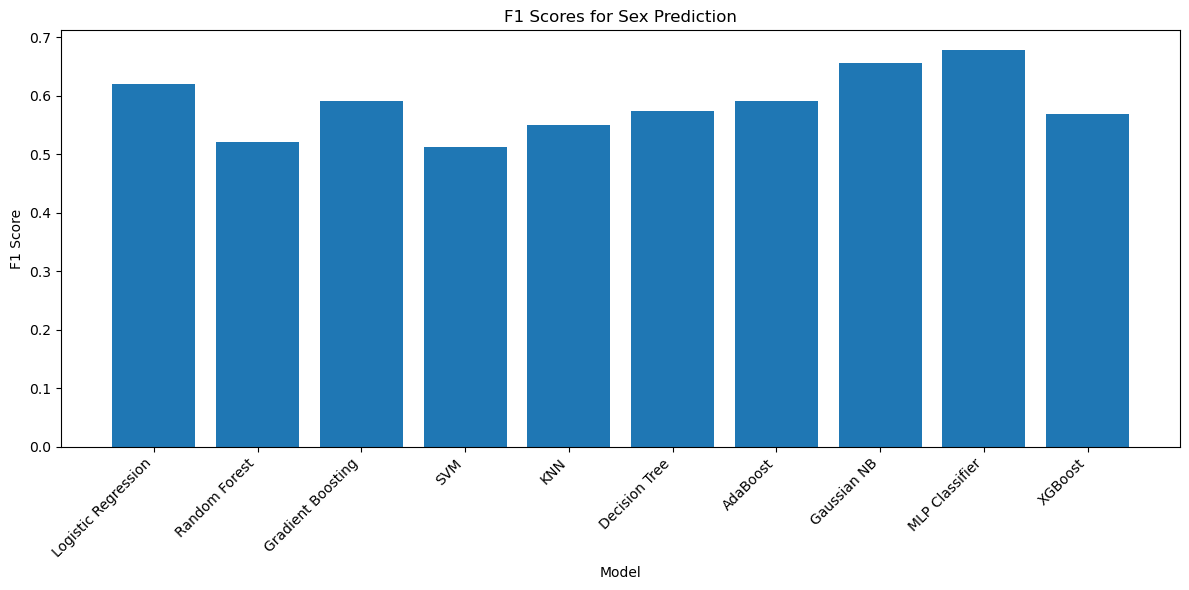

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Assuming train_df_50 and test_df are already loaded

# 1. Data Exploration - Just to verify what we're working with
print("ADHD Outcome categories:", train_df_50["ADHD_Outcome"].unique())
print("Sex_F categories:", train_df_50["Sex_F"].unique())
print("\nADHD Outcome distribution:")
print(train_df_50["ADHD_Outcome"].value_counts())
print("\nSex distribution:")
print(train_df_50["Sex_F"].value_counts())

# 2. Data Preprocessing
# Check for missing values
print("\nMissing values in training data:")
print(train_df_50.isnull().sum())

# Define target variables
y_adhd = train_df_50["ADHD_Outcome"].values
y_sex = train_df_50["Sex_F"].values
Y = np.column_stack((y_adhd, y_sex))

# Get feature columns (excluding the target and any ID columns)
feature_cols = [col for col in train_df_50.columns if col not in ["ADHD_Outcome", "Sex_F", "ID", "participant_id"]]
X = train_df_50[feature_cols]

# Split the data for validation (stratify by one target for simplicity)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=y_adhd)

# Separate the targets for validation
y_train_adhd, y_train_sex = Y_train[:, 0], Y_train[:, 1]
y_val_adhd, y_val_sex = Y_val[:, 0], Y_val[:, 1]

# Create a preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Apply preprocessing to the training and validation data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# 3. Define base ML models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gaussian NB": GaussianNB(),
    "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# 4. Approach 1: Train separate models for each target
# We'll track the best model for each target
adhd_results = {}
sex_results = {}

# Train models for ADHD prediction
print("\n=== ADHD Outcome Prediction Models ===")
for name, model in base_models.items():
    # Fit the model
    model.fit(X_train_processed, y_train_adhd)
    
    # Make predictions
    y_pred = model.predict(X_val_processed)
    
    # Calculate F1 score
    f1 = f1_score(y_val_adhd, y_pred, average='weighted')
    adhd_results[name] = f1
    
    # Print results
    print(f"{name} - F1 Score: {f1:.4f}")
    print(classification_report(y_val_adhd, y_pred))
    print("-" * 50)

# Find the best model for ADHD prediction
best_adhd_model_name = max(adhd_results, key=adhd_results.get)
best_adhd_f1 = adhd_results[best_adhd_model_name]
print(f"\nBest model for ADHD prediction: {best_adhd_model_name} with F1 Score: {best_adhd_f1:.4f}")

# Train models for Sex prediction
print("\n=== Sex Prediction Models ===")
for name, model in base_models.items():
    # Fit the model
    model.fit(X_train_processed, y_train_sex)
    
    # Make predictions
    y_pred = model.predict(X_val_processed)
    
    # Calculate F1 score
    f1 = f1_score(y_val_sex, y_pred, average='weighted')
    sex_results[name] = f1
    
    # Print results
    print(f"{name} - F1 Score: {f1:.4f}")
    print(classification_report(y_val_sex, y_pred))
    print("-" * 50)

# Find the best model for Sex prediction
best_sex_model_name = max(sex_results, key=sex_results.get)
best_sex_f1 = sex_results[best_sex_model_name]
print(f"\nBest model for Sex prediction: {best_sex_model_name} with F1 Score: {best_sex_f1:.4f}")

# 5. Approach 2: Use MultiOutputClassifier for predicting both targets simultaneously
print("\n=== Multi-Output Classification Models ===")
multi_results = {}

for name, base_model in base_models.items():
    # Create multi-output classifier
    multi_model = MultiOutputClassifier(base_model)
    
    # Fit the model
    multi_model.fit(X_train_processed, Y_train)
    
    # Make predictions
    Y_pred = multi_model.predict(X_val_processed)
    y_pred_adhd, y_pred_sex = Y_pred[:, 0], Y_pred[:, 1]
    
    # Calculate F1 scores
    adhd_f1 = f1_score(y_val_adhd, y_pred_adhd, average='weighted')
    sex_f1 = f1_score(y_val_sex, y_pred_sex, average='weighted')
    avg_f1 = (adhd_f1 + sex_f1) / 2
    
    multi_results[name] = avg_f1
    
    # Print results
    print(f"{name} - Average F1 Score: {avg_f1:.4f}")
    print(f"ADHD F1: {adhd_f1:.4f}, Sex F1: {sex_f1:.4f}")
    print("-" * 50)

# Find the best multi-output model
best_multi_model_name = max(multi_results, key=multi_results.get)
best_multi_f1 = multi_results[best_multi_model_name]
print(f"\nBest multi-output model: {best_multi_model_name} with Average F1 Score: {best_multi_f1:.4f}")

# 6. Apply the best models to the test data
print("\n=== Making Predictions on Test Data ===")

# Preprocess test data
X_test = test_df[feature_cols]
X_test_processed = preprocessor.transform(X_test)

# Create final best models
best_adhd_model = base_models[best_adhd_model_name].fit(X_train_processed, y_train_adhd)
best_sex_model = base_models[best_sex_model_name].fit(X_train_processed, y_train_sex)
best_multi_model = MultiOutputClassifier(base_models[best_multi_model_name]).fit(X_train_processed, Y_train)

# Make predictions with individual models
adhd_predictions = best_adhd_model.predict(X_test_processed)
sex_predictions = best_sex_model.predict(X_test_processed)

# Make predictions with multi-output model
multi_predictions = best_multi_model.predict(X_test_processed)
multi_adhd_predictions = multi_predictions[:, 0]
multi_sex_predictions = multi_predictions[:, 1]

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    'participant_id': test_df['participant_id'] if 'participant_id' in test_df.columns else test_df.index,
    'ADHD_Outcome_Prediction': adhd_predictions,
    'Sex_F_Prediction': sex_predictions,
    'ADHD_Outcome_Multi_Prediction': multi_adhd_predictions,
    'Sex_F_Multi_Prediction': multi_sex_predictions
})

# Save predictions to CSV
predictions_df.to_csv('adhd_sex_predictions.csv', index=False)
print("Predictions saved to 'adhd_sex_predictions.csv'")

# 7. Visualizations
# Plot F1 scores for ADHD prediction
plt.figure(figsize=(12, 6))
plt.bar(adhd_results.keys(), adhd_results.values())
plt.title('F1 Scores for ADHD Outcome Prediction')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('adhd_f1_scores.png')

# Plot F1 scores for Sex prediction
plt.figure(figsize=(12, 6))
plt.bar(sex_results.keys(), sex_results.values())
plt.title('F1 Scores for Sex Prediction')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sex_f1_scores.png')

print("Analysis complete. Check the saved visualizations and predictions.")

Using device: cuda:0

Training Simple MLP Model...
Epoch 1/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 2/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 3/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 4/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 5/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 6/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 7/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 8/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 9/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588

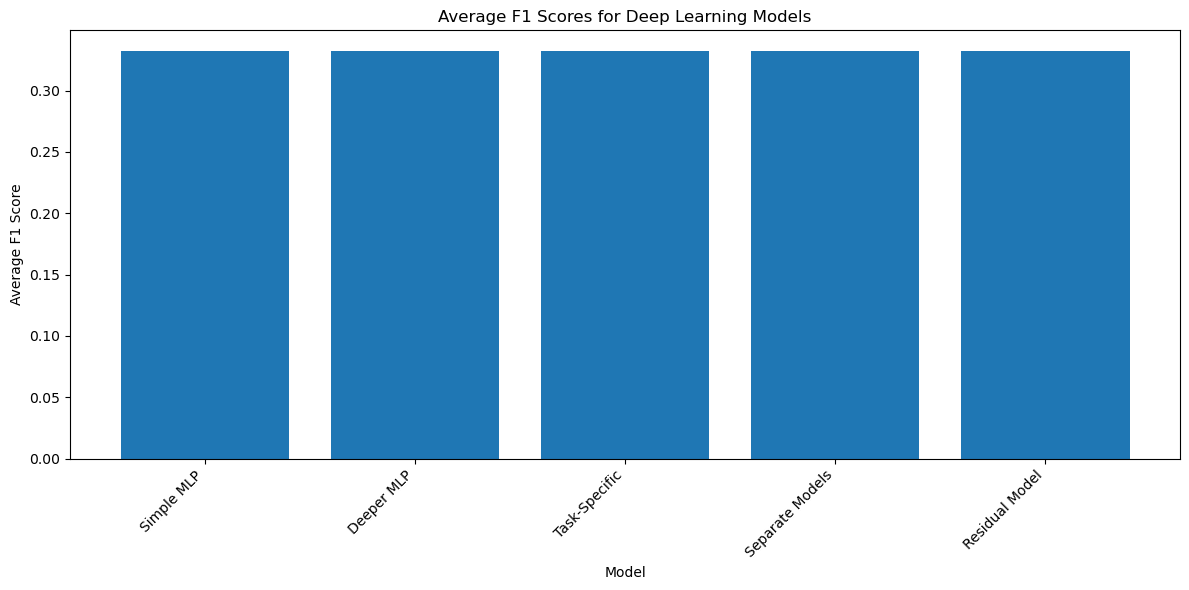

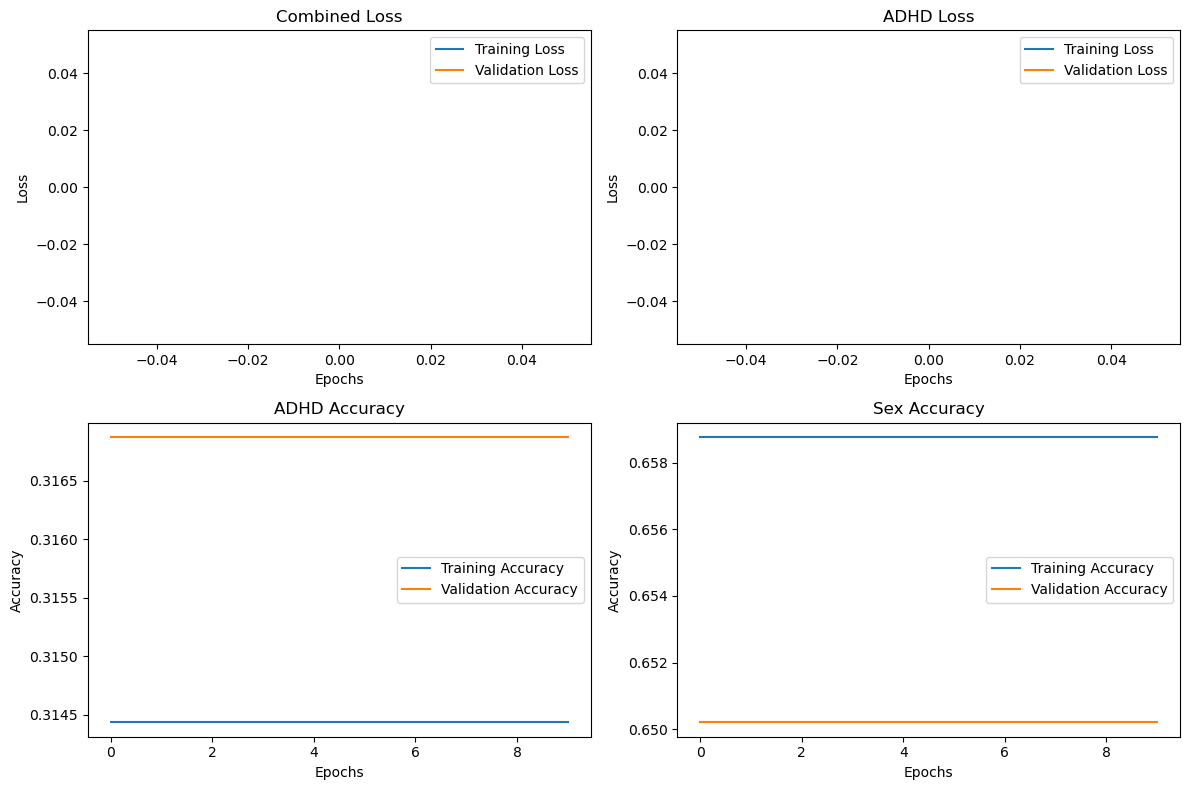

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Preprocessing
# Assuming train_df_50 and test_df are already loaded

# Encode the target variables if needed
if train_df_50["ADHD_Outcome"].dtype == 'object':
    le_adhd = LabelEncoder()
    train_df_50["ADHD_Outcome_encoded"] = le_adhd.fit_transform(train_df_50["ADHD_Outcome"])
    adhd_classes = len(le_adhd.classes_)
    y_adhd = train_df_50["ADHD_Outcome_encoded"].values
else:
    adhd_classes = len(train_df_50["ADHD_Outcome"].unique())
    y_adhd = train_df_50["ADHD_Outcome"].values

if train_df_50["Sex_F"].dtype == 'object':
    le_sex = LabelEncoder()
    train_df_50["Sex_F_encoded"] = le_sex.fit_transform(train_df_50["Sex_F"])
    sex_classes = len(le_sex.classes_)
    y_sex = train_df_50["Sex_F_encoded"].values
else:
    sex_classes = len(train_df_50["Sex_F"].unique())
    y_sex = train_df_50["Sex_F"].values

# Get features (all columns except target variables and IDs)
feature_cols = [col for col in train_df_50.columns if col not in 
                ["ADHD_Outcome", "ADHD_Outcome_encoded", "Sex_F", "Sex_F_encoded", 
                 "ID", "participant_id"]]
X = train_df_50[feature_cols].values

# Split the data
X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    X, y_adhd, y_sex, test_size=0.2, random_state=42, stratify=y_adhd
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_train_adhd_tensor = torch.LongTensor(y_train_adhd)
y_val_adhd_tensor = torch.LongTensor(y_val_adhd)
y_train_sex_tensor = torch.LongTensor(y_train_sex)
y_val_sex_tensor = torch.LongTensor(y_val_sex)

# Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_adhd_tensor, y_train_sex_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_adhd_tensor, y_val_sex_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 2. Define PyTorch Deep Learning Models

# Model 1: Simple MLP for Multi-task Learning
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, adhd_classes, sex_classes):
        super(SimpleMLP, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        shared_features = self.shared_layers(x)
        adhd_output = self.adhd_classifier(shared_features)
        sex_output = self.sex_classifier(shared_features)
        return adhd_output, sex_output

# Model 2: Deeper MLP with more regularization
class DeeperMLP(nn.Module):
    def __init__(self, input_dim, adhd_classes, sex_classes):
        super(DeeperMLP, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        shared_features = self.shared_layers(x)
        adhd_output = self.adhd_classifier(shared_features)
        sex_output = self.sex_classifier(shared_features)
        return adhd_output, sex_output

# Model 3: Task-specific networks
class TaskSpecificModel(nn.Module):
    def __init__(self, input_dim, adhd_classes, sex_classes):
        super(TaskSpecificModel, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        # ADHD-specific branch
        self.adhd_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        
        # Sex-specific branch
        self.sex_branch = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        shared_features = self.shared_layers(x)
        
        adhd_features = self.adhd_branch(shared_features)
        adhd_output = self.adhd_classifier(adhd_features)
        
        sex_features = self.sex_branch(shared_features)
        sex_output = self.sex_classifier(sex_features)
        
        return adhd_output, sex_output

# Model 4: Separate models for each task
class ADHDModel(nn.Module):
    def __init__(self, input_dim, adhd_classes):
        super(ADHDModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, adhd_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

class SexModel(nn.Module):
    def __init__(self, input_dim, sex_classes):
        super(SexModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, sex_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Model 5: Residual connections model
class ResidualModel(nn.Module):
    def __init__(self, input_dim, adhd_classes, sex_classes):
        super(ResidualModel, self).__init__()
        
        # First block
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        # Second block
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        # Final layer with combined features
        self.final = nn.Sequential(
            nn.Linear(256, 64),  # 128 (block1) + 128 (block2) = 256
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        
        # Concatenate block1 and block2 outputs (residual connection)
        combined = torch.cat((x1, x2), dim=1)
        
        features = self.final(combined)
        adhd_output = self.adhd_classifier(features)
        sex_output = self.sex_classifier(features)
        
        return adhd_output, sex_output

# 3. Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    model = model.to(device)
    
    # Early stopping setup
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_adhd_loss': [], 'val_adhd_loss': [],
        'train_sex_loss': [], 'val_sex_loss': [],
        'train_adhd_acc': [], 'val_adhd_acc': [],
        'train_sex_acc': [], 'val_sex_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_adhd_loss = 0.0
        train_sex_loss = 0.0
        train_adhd_correct = 0
        train_sex_correct = 0
        train_samples = 0
        
        for inputs, adhd_labels, sex_labels in train_loader:
            inputs = inputs.to(device)
            adhd_labels = adhd_labels.to(device)
            sex_labels = sex_labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            adhd_outputs, sex_outputs = model(inputs)
            adhd_loss = criterion(adhd_outputs, adhd_labels)
            sex_loss = criterion(sex_outputs, sex_labels)
            loss = adhd_loss + sex_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * inputs.size(0)
            train_adhd_loss += adhd_loss.item() * inputs.size(0)
            train_sex_loss += sex_loss.item() * inputs.size(0)
            
            _, adhd_preds = torch.max(adhd_outputs, 1)
            _, sex_preds = torch.max(sex_outputs, 1)
            train_adhd_correct += (adhd_preds == adhd_labels).sum().item()
            train_sex_correct += (sex_preds == sex_labels).sum().item()
            train_samples += inputs.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_adhd_loss = 0.0
        val_sex_loss = 0.0
        val_adhd_correct = 0
        val_sex_correct = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, adhd_labels, sex_labels in val_loader:
                inputs = inputs.to(device)
                adhd_labels = adhd_labels.to(device)
                sex_labels = sex_labels.to(device)
                
                # Forward pass
                adhd_outputs, sex_outputs = model(inputs)
                adhd_loss = criterion(adhd_outputs, adhd_labels)
                sex_loss = criterion(sex_outputs, sex_labels)
                loss = adhd_loss + sex_loss
                
                # Calculate metrics
                val_loss += loss.item() * inputs.size(0)
                val_adhd_loss += adhd_loss.item() * inputs.size(0)
                val_sex_loss += sex_loss.item() * inputs.size(0)
                
                _, adhd_preds = torch.max(adhd_outputs, 1)
                _, sex_preds = torch.max(sex_outputs, 1)
                val_adhd_correct += (adhd_preds == adhd_labels).sum().item()
                val_sex_correct += (sex_preds == sex_labels).sum().item()
                val_samples += inputs.size(0)
        
        # Calculate average losses and accuracies
        train_loss /= train_samples
        train_adhd_loss /= train_samples
        train_sex_loss /= train_samples
        train_adhd_acc = train_adhd_correct / train_samples
        train_sex_acc = train_sex_correct / train_samples
        
        val_loss /= val_samples
        val_adhd_loss /= val_samples
        val_sex_loss /= val_samples
        val_adhd_acc = val_adhd_correct / val_samples
        val_sex_acc = val_sex_correct / val_samples
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_adhd_loss'].append(train_adhd_loss)
        history['val_adhd_loss'].append(val_adhd_loss)
        history['train_sex_loss'].append(train_sex_loss)
        history['val_sex_loss'].append(val_sex_loss)
        history['train_adhd_acc'].append(train_adhd_acc)
        history['val_adhd_acc'].append(val_adhd_acc)
        history['train_sex_acc'].append(train_sex_acc)
        history['val_sex_acc'].append(val_sex_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, ADHD Acc: {train_adhd_acc:.4f}, Sex Acc: {train_sex_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, ADHD Acc: {val_adhd_acc:.4f}, Sex Acc: {val_sex_acc:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            
        if no_improve_epochs >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return model, history

def train_separate_models(adhd_model, sex_model, train_loader, val_loader, criterion, adhd_optimizer, sex_optimizer, num_epochs=50, patience=10):
    adhd_model = adhd_model.to(device)
    sex_model = sex_model.to(device)
    
    # Early stopping setup
    best_adhd_val_loss = float('inf')
    best_sex_val_loss = float('inf')
    best_adhd_model_state = None
    best_sex_model_state = None
    adhd_no_improve = 0
    sex_no_improve = 0
    
    # Training history
    adhd_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    sex_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        adhd_model.train()
        sex_model.train()
        
        adhd_train_loss = 0.0
        sex_train_loss = 0.0
        adhd_train_correct = 0
        sex_train_correct = 0
        train_samples = 0
        
        for inputs, adhd_labels, sex_labels in train_loader:
            inputs = inputs.to(device)
            adhd_labels = adhd_labels.to(device)
            sex_labels = sex_labels.to(device)
            
            # ADHD model
            adhd_optimizer.zero_grad()
            adhd_outputs = adhd_model(inputs)
            adhd_loss = criterion(adhd_outputs, adhd_labels)
            adhd_loss.backward()
            adhd_optimizer.step()
            
            # Sex model
            sex_optimizer.zero_grad()
            sex_outputs = sex_model(inputs)
            sex_loss = criterion(sex_outputs, sex_labels)
            sex_loss.backward()
            sex_optimizer.step()
            
            # Calculate metrics
            adhd_train_loss += adhd_loss.item() * inputs.size(0)
            sex_train_loss += sex_loss.item() * inputs.size(0)
            
            _, adhd_preds = torch.max(adhd_outputs, 1)
            _, sex_preds = torch.max(sex_outputs, 1)
            adhd_train_correct += (adhd_preds == adhd_labels).sum().item()
            sex_train_correct += (sex_preds == sex_labels).sum().item()
            train_samples += inputs.size(0)
        
        # Validation phase
        adhd_model.eval()
        sex_model.eval()
        
        adhd_val_loss = 0.0
        sex_val_loss = 0.0
        adhd_val_correct = 0
        sex_val_correct = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, adhd_labels, sex_labels in val_loader:
                inputs = inputs.to(device)
                adhd_labels = adhd_labels.to(device)
                sex_labels = sex_labels.to(device)
                
                # Forward pass
                adhd_outputs = adhd_model(inputs)
                sex_outputs = sex_model(inputs)
                
                adhd_loss = criterion(adhd_outputs, adhd_labels)
                sex_loss = criterion(sex_outputs, sex_labels)
                
                # Calculate metrics
                adhd_val_loss += adhd_loss.item() * inputs.size(0)
                sex_val_loss += sex_loss.item() * inputs.size(0)
                
                _, adhd_preds = torch.max(adhd_outputs, 1)
                _, sex_preds = torch.max(sex_outputs, 1)
                adhd_val_correct += (adhd_preds == adhd_labels).sum().item()
                sex_val_correct += (sex_preds == sex_labels).sum().item()
                val_samples += inputs.size(0)
        
        # Calculate average losses and accuracies
        adhd_train_loss /= train_samples
        sex_train_loss /= train_samples
        adhd_train_acc = adhd_train_correct / train_samples
        sex_train_acc = sex_train_correct / train_samples
        
        adhd_val_loss /= val_samples
        sex_val_loss /= val_samples
        adhd_val_acc = adhd_val_correct / val_samples
        sex_val_acc = sex_val_correct / val_samples
        
        # Store history
        adhd_history['train_loss'].append(adhd_train_loss)
        adhd_history['val_loss'].append(adhd_val_loss)
        adhd_history['train_acc'].append(adhd_train_acc)
        adhd_history['val_acc'].append(adhd_val_acc)
        
        sex_history['train_loss'].append(sex_train_loss)
        sex_history['val_loss'].append(sex_val_loss)
        sex_history['train_acc'].append(sex_train_acc)
        sex_history['val_acc'].append(sex_val_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'ADHD - Train Loss: {adhd_train_loss:.4f}, Acc: {adhd_train_acc:.4f}, Val Loss: {adhd_val_loss:.4f}, Val Acc: {adhd_val_acc:.4f}')
        print(f'Sex - Train Loss: {sex_train_loss:.4f}, Acc: {sex_train_acc:.4f}, Val Loss: {sex_val_loss:.4f}, Val Acc: {sex_val_acc:.4f}')
        
        # Early stopping check for ADHD model
        if adhd_val_loss < best_adhd_val_loss:
            best_adhd_val_loss = adhd_val_loss
            best_adhd_model_state = adhd_model.state_dict().copy()
            adhd_no_improve = 0
        else:
            adhd_no_improve += 1
        
        # Early stopping check for Sex model
        if sex_val_loss < best_sex_val_loss:
            best_sex_val_loss = sex_val_loss
            best_sex_model_state = sex_model.state_dict().copy()
            sex_no_improve = 0
        else:
            sex_no_improve += 1
            
        if adhd_no_improve >= patience and sex_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best models
    if best_adhd_model_state is not None:
        adhd_model.load_state_dict(best_adhd_model_state)
    if best_sex_model_state is not None:
        sex_model.load_state_dict(best_sex_model_state)
        
    return adhd_model, sex_model, adhd_history, sex_history

def evaluate_model(model, data_loader, is_separate_models=False):
    if is_separate_models:
        adhd_model, sex_model = model
        adhd_model.eval()
        sex_model.eval()
    else:
        model.eval()
    
    adhd_true = []
    adhd_pred = []
    sex_true = []
    sex_pred = []
    
    with torch.no_grad():
        for inputs, adhd_labels, sex_labels in data_loader:
            inputs = inputs.to(device)
            
            if is_separate_models:
                adhd_outputs = adhd_model(inputs)
                sex_outputs = sex_model(inputs)
            else:
                adhd_outputs, sex_outputs = model(inputs)
            
            _, adhd_preds = torch.max(adhd_outputs, 1)
            _, sex_preds = torch.max(sex_outputs, 1)
            
            adhd_true.extend(adhd_labels.cpu().numpy())
            adhd_pred.extend(adhd_preds.cpu().numpy())
            sex_true.extend(sex_labels.cpu().numpy())
            sex_pred.extend(sex_preds.cpu().numpy())
    
    # Calculate F1 scores
    adhd_f1 = f1_score(adhd_true, adhd_pred, average='weighted')
    sex_f1 = f1_score(sex_true, sex_pred, average='weighted')
    avg_f1 = (adhd_f1 + sex_f1) / 2
    
    # Generate classification reports
    adhd_report = classification_report(adhd_true, adhd_pred)
    sex_report = classification_report(sex_true, sex_pred)
    
    return adhd_f1, sex_f1, avg_f1, adhd_report, sex_report

# 4. Initialize and Train Models
input_dim = X_train_scaled.shape[1]
criterion = nn.CrossEntropyLoss()

# Model 1: Simple MLP
print("\nTraining Simple MLP Model...")
model1 = SimpleMLP(input_dim, adhd_classes, sex_classes)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
model1, history1 = train_model(model1, train_loader, val_loader, criterion, optimizer1)

# Model 2: Deeper MLP
print("\nTraining Deeper MLP Model...")
model2 = DeeperMLP(input_dim, adhd_classes, sex_classes)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005, weight_decay=1e-4)
model2, history2 = train_model(model2, train_loader, val_loader, criterion, optimizer2)

# Model 3: Task-specific Model
print("\nTraining Task-Specific Model...")
model3 = TaskSpecificModel(input_dim, adhd_classes, sex_classes)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001, weight_decay=1e-4)
model3, history3 = train_model(model3, train_loader, val_loader, criterion, optimizer3)

# Model 4: Separate Models
print("\nTraining Separate Models...")
adhd_model = ADHDModel(input_dim, adhd_classes)
sex_model = SexModel(input_dim, sex_classes)
adhd_optimizer = optim.Adam(adhd_model.parameters(), lr=0.001, weight_decay=1e-4)
sex_optimizer = optim.Adam(sex_model.parameters(), lr=0.001, weight_decay=1e-4)
adhd_model, sex_model, adhd_history, sex_history = train_separate_models(
    adhd_model, sex_model, train_loader, val_loader, criterion, adhd_optimizer, sex_optimizer
)

# Model 5: Residual Model
print("\nTraining Residual Model...")
model5 = ResidualModel(input_dim, adhd_classes, sex_classes)
optimizer5 = optim.Adam(model5.parameters(), lr=0.001, weight_decay=1e-4)
model5, history5 = train_model(model5, train_loader, val_loader, criterion, optimizer5)

# 5. Evaluate all models
print("\n=== Model Evaluation on Validation Set ===")
f1_model1 = evaluate_model(model1, val_loader)
print("\nSimple MLP - Average F1 Score: {:.4f}".format(f1_model1[2]))
print("ADHD F1 Score: {:.4f}".format(f1_model1[0]))
print("Sex F1 Score: {:.4f}".format(f1_model1[1]))
print("\nADHD Classification Report:")
print(f1_model1[3])
print("\nSex Classification Report:")
print(f1_model1[4])

f1_model2 = evaluate_model(model2, val_loader)
print("\nDeeper MLP - Average F1 Score: {:.4f}".format(f1_model2[2]))
print("ADHD F1 Score: {:.4f}".format(f1_model2[0]))
print("Sex F1 Score: {:.4f}".format(f1_model2[1]))
print("\nADHD Classification Report:")
print(f1_model2[3])
print("\nSex Classification Report:")
print(f1_model2[4])

f1_model3 = evaluate_model(model3, val_loader)
print("\nTask-Specific Model - Average F1 Score: {:.4f}".format(f1_model3[2]))
print("ADHD F1 Score: {:.4f}".format(f1_model3[0]))
print("Sex F1 Score: {:.4f}".format(f1_model3[1]))
print("\nADHD Classification Report:")
print(f1_model3[3])
print("\nSex Classification Report:")
print(f1_model3[4])

f1_model4 = evaluate_model((adhd_model, sex_model), val_loader, is_separate_models=True)
print("\nSeparate Models - Average F1 Score: {:.4f}".format(f1_model4[2]))
print("ADHD F1 Score: {:.4f}".format(f1_model4[0]))
print("Sex F1 Score: {:.4f}".format(f1_model4[1]))
print("\nADHD Classification Report:")
print(f1_model4[3])
print("\nSex Classification Report:")
print(f1_model4[4])

f1_model5 = evaluate_model(model5, val_loader)
print("\nResidual Model - Average F1 Score: {:.4f}".format(f1_model5[2]))
print("ADHD F1 Score: {:.4f}".format(f1_model5[0]))
print("Sex F1 Score: {:.4f}".format(f1_model5[1]))
print("\nADHD Classification Report:")
print(f1_model5[3])
print("\nSex Classification Report:")
print(f1_model5[4])

# Store F1 scores
f1_scores = {
    "Simple MLP": f1_model1[2],
    "Deeper MLP": f1_model2[2],
    "Task-Specific": f1_model3[2],
    "Separate Models": f1_model4[2],
    "Residual Model": f1_model5[2]
}

# Find the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1 = f1_scores[best_model_name]
print(f"\nBest Deep Learning Model: {best_model_name} with Average F1 Score: {best_f1:.4f}")

# 6. Apply the best model to the test set
print("\n=== Making Predictions on Test Data ===")

# Preprocess test data
X_test = test_df[feature_cols].values
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Get the best model
if best_model_name == "Simple MLP":
    best_model = model1
elif best_model_name == "Deeper MLP":
    best_model = model2
elif best_model_name == "Task-Specific":
    best_model = model3
elif best_model_name == "Separate Models":
    best_model = (adhd_model, sex_model)
else:  # Residual Model
    best_model = model5

# Make predictions
if best_model_name == "Separate Models":
    adhd_model, sex_model = best_model
    adhd_model.eval()
    sex_model.eval()
    
    with torch.no_grad():
        adhd_preds = adhd_model(X_test_tensor)
        sex_preds = sex_model(X_test_tensor)
    
    # Convert to class indices
    adhd_pred_classes = torch.argmax(adhd_preds, dim=1).cpu().numpy()
    sex_pred_classes = torch.argmax(sex_preds, dim=1).cpu().numpy()
    
else:
    best_model.eval()
    
    with torch.no_grad():
        adhd_preds, sex_preds = best_model(X_test_tensor)
    
    # Convert to class indices
    adhd_pred_classes = torch.argmax(adhd_preds, dim=1).cpu().numpy()
    sex_pred_classes = torch.argmax(sex_preds, dim=1).cpu().numpy()

# Convert back to original labels if encoding was used
if 'le_adhd' in locals():
    adhd_pred_labels = le_adhd.inverse_transform(adhd_pred_classes)
else:
    adhd_pred_labels = adhd_pred_classes

if 'le_sex' in locals():
    sex_pred_labels = le_sex.inverse_transform(sex_pred_classes)
else:
    sex_pred_labels = sex_pred_classes

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'participant_id': test_df['participant_id'] if 'participant_id' in test_df.columns else test_df.index,
    'ADHD_Outcome_Prediction': adhd_pred_labels,
    'Sex_F_Prediction': sex_pred_labels
})

# Save predictions to CSV
predictions_df.to_csv('pytorch_adhd_sex_predictions.csv', index=False)
print("PyTorch predictions saved to 'pytorch_adhd_sex_predictions.csv'")

# 7. Visualize results
# Plot F1 scores for all models
plt.figure(figsize=(12, 6))
models = list(f1_scores.keys())
scores = list(f1_scores.values())
plt.bar(models, scores)
plt.title('Average F1 Scores for Deep Learning Models')
plt.xlabel('Model')
plt.ylabel('Average F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pytorch_model_f1_scores.png')

# Plot learning curves for the best model
plt.figure(figsize=(12, 8))

if best_model_name == "Separate Models":
    # Plot ADHD model learning curves
    plt.subplot(2, 2, 1)
    plt.plot(adhd_history['train_loss'], label='Training Loss')
    plt.plot(adhd_history['val_loss'], label='Validation Loss')
    plt.title('ADHD Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(adhd_history['train_acc'], label='Training Accuracy')
    plt.plot(adhd_history['val_acc'], label='Validation Accuracy')
    plt.title('ADHD Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Sex model learning curves
    plt.subplot(2, 2, 3)
    plt.plot(sex_history['train_loss'], label='Training Loss')
    plt.plot(sex_history['val_loss'], label='Validation Loss')
    plt.title('Sex Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(sex_history['train_acc'], label='Training Accuracy')
    plt.plot(sex_history['val_acc'], label='Validation Accuracy')
    plt.title('Sex Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    # Get the appropriate history object
    if best_model_name == "Simple MLP":
        history = history1
    elif best_model_name == "Deeper MLP":
        history = history2
    elif best_model_name == "Task-Specific":
        history = history3
    else:  # "Residual Model"
        history = history5
    
    # Plot combined loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Combined Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot ADHD loss
    plt.subplot(2, 2, 2)
    plt.plot(history['train_adhd_loss'], label='Training Loss')
    plt.plot(history['val_adhd_loss'], label='Validation Loss')
    plt.title('ADHD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot ADHD accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history['train_adhd_acc'], label='Training Accuracy')
    plt.plot(history['val_adhd_acc'], label='Validation Accuracy')
    plt.title('ADHD Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Sex accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history['train_sex_acc'], label='Training Accuracy')
    plt.plot(history['val_sex_acc'], label='Validation Accuracy')
    plt.title('Sex Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.savefig('pytorch_best_model_learning_curves.png')

print("\nAnalysis complete. Check the saved visualizations and predictions.")

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Preprocessing
# Assuming train_df_50 and test_df are already loaded

# Encode the target variables if needed
if train_df_50["ADHD_Outcome"].dtype == 'object':
    le_adhd = LabelEncoder()
    train_df_50["ADHD_Outcome_encoded"] = le_adhd.fit_transform(train_df_50["ADHD_Outcome"])
    adhd_classes = len(le_adhd.classes_)
    y_adhd = train_df_50["ADHD_Outcome_encoded"].values
else:
    adhd_classes = len(train_df_50["ADHD_Outcome"].unique())
    y_adhd = train_df_50["ADHD_Outcome"].values

if train_df_50["Sex_F"].dtype == 'object':
    le_sex = LabelEncoder()
    train_df_50["Sex_F_encoded"] = le_sex.fit_transform(train_df_50["Sex_F"])
    sex_classes = len(le_sex.classes_)
    y_sex = train_df_50["Sex_F_encoded"].values
else:
    sex_classes = len(train_df_50["Sex_F"].unique())
    y_sex = train_df_50["Sex_F"].values

# Get features (all columns except target variables and IDs)
feature_cols = [col for col in train_df_50.columns if col not in 
                ["ADHD_Outcome", "ADHD_Outcome_encoded", "Sex_F", "Sex_F_encoded", 
                 "ID", "participant_id"]]
X = train_df_50[feature_cols].values

# Split the data
X_train, X_val, y_train_adhd, y_val_adhd, y_train_sex, y_val_sex = train_test_split(
    X, y_adhd, y_sex, test_size=0.2, random_state=42, stratify=y_adhd
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_train_adhd_tensor = torch.LongTensor(y_train_adhd)
y_val_adhd_tensor = torch.LongTensor(y_val_adhd)
y_train_sex_tensor = torch.LongTensor(y_train_sex)
y_val_sex_tensor = torch.LongTensor(y_val_sex)

# Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_adhd_tensor, y_train_sex_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_adhd_tensor, y_val_sex_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 2. Define Advanced PyTorch Models

# Model 1: Deep Neural Network (DNN)
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_dim, adhd_classes, sex_classes):
        super(DeepNeuralNetwork, self).__init__()
        # Much deeper architecture
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        shared_features = self.shared_layers(x)
        adhd_output = self.adhd_classifier(shared_features)
        sex_output = self.sex_classifier(shared_features)
        return adhd_output, sex_output

# Model 2: RNN (Recurrent Neural Network)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, adhd_classes, sex_classes, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=1,  # Each feature at a time
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        # Output layers
        self.fc = nn.Linear(hidden_dim, 64)
        self.dropout = nn.Dropout(0.3)
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        # Reshape input to (batch, seq_len, features)
        # For tabular data, we treat each feature as a time step
        x = x.unsqueeze(2)  # Add feature dimension
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply additional FC layer and dropout
        out = self.fc(out)
        out = torch.relu(out)
        out = self.dropout(out)
        
        # Output layers
        adhd_output = self.adhd_classifier(out)
        sex_output = self.sex_classifier(out)
        
        return adhd_output, sex_output

# Model 3: GRU (Gated Recurrent Unit)
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, adhd_classes, sex_classes, num_layers=2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=1,  # Each feature at a time
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        # Output layers
        self.fc = nn.Linear(hidden_dim, 64)
        self.dropout = nn.Dropout(0.3)
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        # Reshape input to (batch, seq_len, features)
        x = x.unsqueeze(2)  # Add feature dimension
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply additional FC layer and dropout
        out = self.fc(out)
        out = torch.relu(out)
        out = self.dropout(out)
        
        # Output layers
        adhd_output = self.adhd_classifier(out)
        sex_output = self.sex_classifier(out)
        
        return adhd_output, sex_output

# Model 4: Attention LSTM
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, adhd_classes, sex_classes, num_layers=2):
        super(AttentionLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=1,  # Each feature at a time
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Bidirectional, so hidden_dim * 2
        
        # Output layers
        self.fc = nn.Linear(hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def attention_net(self, lstm_output):
        # lstm_output shape: (batch_size, seq_len, hidden_dim*2)
        attn_weights = self.attention(lstm_output)  # (batch_size, seq_len, 1)
        attn_weights = torch.tanh(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)  # (batch_size, seq_len, 1)
        
        # Multiply attention weights with LSTM output
        context = torch.bmm(lstm_output.transpose(1, 2), attn_weights)  # (batch_size, hidden_dim*2, 1)
        context = context.squeeze(2)  # (batch_size, hidden_dim*2)
        
        return context
        
    def forward(self, x):
        # Reshape input to (batch, seq_len, features)
        x = x.unsqueeze(2)  # Add feature dimension
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # Bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(x.device)  # Bidirectional
        
        # Forward propagate LSTM
        lstm_output, _ = self.lstm(x, (h0, c0))
        
        # Apply attention
        attn_output = self.attention_net(lstm_output)
        
        # Apply FC layer and dropout
        out = self.fc(attn_output)
        out = torch.relu(out)
        out = self.dropout(out)
        
        # Output layers
        adhd_output = self.adhd_classifier(out)
        sex_output = self.sex_classifier(out)
        
        return adhd_output, sex_output

# Model 5: Transformer-based Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, adhd_classes, sex_classes, dropout=0.3):
        super(TransformerModel, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(1, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Output layers
        self.fc = nn.Linear(d_model, 64)
        self.dropout = nn.Dropout(dropout)
        self.adhd_classifier = nn.Linear(64, adhd_classes)
        self.sex_classifier = nn.Linear(64, sex_classes)
        
    def forward(self, x):
        # Reshape input to (batch, seq_len, features)
        x = x.unsqueeze(2)  # Add feature dimension
        
        # Project input to d_model dimensions
        x = self.input_projection(x)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Reshape for transformer: (seq_len, batch, d_model)
        x = x.transpose(0, 1)
        
        # Apply transformer
        transformer_output = self.transformer_encoder(x)
        
        # Use the output from the last position
        out = transformer_output[-1]
        
        # Apply FC layer and dropout
        out = self.fc(out)
        out = torch.relu(out)
        out = self.dropout(out)
        
        # Output layers
        adhd_output = self.adhd_classifier(out)
        sex_output = self.sex_classifier(out)
        
        return adhd_output, sex_output

# 3. Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    model = model.to(device)
    
    # Early stopping setup
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_adhd_loss': [], 'val_adhd_loss': [],
        'train_sex_loss': [], 'val_sex_loss': [],
        'train_adhd_acc': [], 'val_adhd_acc': [],
        'train_sex_acc': [], 'val_sex_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_adhd_loss = 0.0
        train_sex_loss = 0.0
        train_adhd_correct = 0
        train_sex_correct = 0
        train_samples = 0
        
        for inputs, adhd_labels, sex_labels in train_loader:
            inputs = inputs.to(device)
            adhd_labels = adhd_labels.to(device)
            sex_labels = sex_labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            adhd_outputs, sex_outputs = model(inputs)
            adhd_loss = criterion(adhd_outputs, adhd_labels)
            sex_loss = criterion(sex_outputs, sex_labels)
            loss = adhd_loss + sex_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * inputs.size(0)
            train_adhd_loss += adhd_loss.item() * inputs.size(0)
            train_sex_loss += sex_loss.item() * inputs.size(0)
            
            _, adhd_preds = torch.max(adhd_outputs, 1)
            _, sex_preds = torch.max(sex_outputs, 1)
            train_adhd_correct += (adhd_preds == adhd_labels).sum().item()
            train_sex_correct += (sex_preds == sex_labels).sum().item()
            train_samples += inputs.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_adhd_loss = 0.0
        val_sex_loss = 0.0
        val_adhd_correct = 0
        val_sex_correct = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, adhd_labels, sex_labels in val_loader:
                inputs = inputs.to(device)
                adhd_labels = adhd_labels.to(device)
                sex_labels = sex_labels.to(device)
                
                # Forward pass
                adhd_outputs, sex_outputs = model(inputs)
                adhd_loss = criterion(adhd_outputs, adhd_labels)
                sex_loss = criterion(sex_outputs, sex_labels)
                loss = adhd_loss + sex_loss
                
                # Calculate metrics
                val_loss += loss.item() * inputs.size(0)
                val_adhd_loss += adhd_loss.item() * inputs.size(0)
                val_sex_loss += sex_loss.item() * inputs.size(0)
                
                _, adhd_preds = torch.max(adhd_outputs, 1)
                _, sex_preds = torch.max(sex_outputs, 1)
                val_adhd_correct += (adhd_preds == adhd_labels).sum().item()
                val_sex_correct += (sex_preds == sex_labels).sum().item()
                val_samples += inputs.size(0)
        
        # Calculate average losses and accuracies
        train_loss /= train_samples
        train_adhd_loss /= train_samples
        train_sex_loss /= train_samples
        train_adhd_acc = train_adhd_correct / train_samples
        train_sex_acc = train_sex_correct / train_samples
        
        val_loss /= val_samples
        val_adhd_loss /= val_samples
        val_sex_loss /= val_samples
        val_adhd_acc = val_adhd_correct / val_samples
        val_sex_acc = val_sex_correct / val_samples
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_adhd_loss'].append(train_adhd_loss)
        history['val_adhd_loss'].append(val_adhd_loss)
        history['train_sex_loss'].append(train_sex_loss)
        history['val_sex_loss'].append(val_sex_loss)
        history['train_adhd_acc'].append(train_adhd_acc)
        history['val_adhd_acc'].append(val_adhd_acc)
        history['train_sex_acc'].append(train_sex_acc)
        history['val_sex_acc'].append(val_sex_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, ADHD Acc: {train_adhd_acc:.4f}, Sex Acc: {train_sex_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, ADHD Acc: {val_adhd_acc:.4f}, Sex Acc: {val_sex_acc:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            
        if no_improve_epochs >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return model, history

def evaluate_model(model, data_loader):
    model.eval()
    
    adhd_true = []
    adhd_pred = []
    sex_true = []
    sex_pred = []
    
    with torch.no_grad():
        for inputs, adhd_labels, sex_labels in data_loader:
            inputs = inputs.to(device)
            
            adhd_outputs, sex_outputs = model(inputs)
            
            _, adhd_preds = torch.max(adhd_outputs, 1)
            _, sex_preds = torch.max(sex_outputs, 1)
            
            adhd_true.extend(adhd_labels.cpu().numpy())
            adhd_pred.extend(adhd_preds.cpu().numpy())
            sex_true.extend(sex_labels.cpu().numpy())
            sex_pred.extend(sex_preds.cpu().numpy())
    
    # Calculate F1 scores
    adhd_f1 = f1_score(adhd_true, adhd_pred, average='weighted')
    sex_f1 = f1_score(sex_true, sex_pred, average='weighted')
    avg_f1 = (adhd_f1 + sex_f1) / 2
    
    # Generate classification reports
    adhd_report = classification_report(adhd_true, adhd_pred)
    sex_report = classification_report(sex_true, sex_pred)
    
    return adhd_f1, sex_f1, avg_f1, adhd_report, sex_report

# 4. Initialize and Train Models
input_dim = X_train_scaled.shape[1]
criterion = nn.CrossEntropyLoss()

# Model 1: Deep Neural Network
print("\nTraining Deep Neural Network (DNN) Model...")
dnn_model = DeepNeuralNetwork(input_dim, adhd_classes, sex_classes)
dnn_optimizer = optim.Adam(dnn_model.parameters(), lr=0.0005, weight_decay=1e-4)
dnn_model, dnn_history = train_model(dnn_model, train_loader, val_loader, criterion, dnn_optimizer)

# Model 2: RNN
print("\nTraining RNN Model...")
hidden_dim = 128
rnn_model = RNNModel(input_dim, hidden_dim, adhd_classes, sex_classes)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
rnn_model, rnn_history = train_model(rnn_model, train_loader, val_loader, criterion, rnn_optimizer)

# Model 3: GRU
print("\nTraining GRU Model...")
gru_model = GRUModel(input_dim, hidden_dim, adhd_classes, sex_classes)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001, weight_decay=1e-4)
gru_model, gru_history = train_model(gru_model, train_loader, val_loader, criterion, gru_optimizer)

# Model 4: Attention LSTM
print("\nTraining Attention LSTM Model...")
lstm_model = AttentionLSTM(input_dim, hidden_dim, adhd_classes, sex_classes)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-4)
lstm_model, lstm_history = train_model(lstm_model, train_loader, val_loader, criterion, lstm_optimizer)

# Model 5: Transformer
print("\nTraining Transformer Model...")
d_model = 64
nhead = 4
transformer_layers = 2
transformer_model = TransformerModel(input_dim, d_model, nhead, transformer_layers, adhd_classes, sex_classes)
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.0005, weight_decay=1e-4)
transformer_model, transformer_history = train_model(transformer_model, train_loader, val_loader, criterion, transformer_optimizer)

# 5. Evaluate all models
print("\n=== Model Evaluation on Validation Set ===")
f1_dnn = evaluate_model(dnn_model, val_loader)
print("\nDNN - Average F1 Score: {:.4f}".format(f1_dnn[2]))
print("ADHD F1 Score: {:.4f}".format(f1_dnn[0]))
print("Sex F1 Score: {:.4f}".format(f1_dnn[1]))
print("\nADHD Classification Report:")
print(f1_dnn[3])
print("\nSex Classification Report:")
print(f1_dnn[4])

f1_rnn = evaluate_model(rnn_model, val_loader)
print("\nRNN - Average F1 Score: {:.4f}".format(f1_rnn[2]))
print("ADHD F1 Score: {:.4f}".format(f1_rnn[0]))
print("Sex F1 Score: {:.4f}".format(f1_rnn[1]))
print("\nADHD Classification Report:")
print(f1_rnn[3])
print("\nSex Classification Report:")
print(f1_rnn[4])

f1_gru = evaluate_model(gru_model, val_loader)
print("\nGRU - Average F1 Score: {:.4f}".format(f1_gru[2]))
print("ADHD F1 Score: {:.4f}".format(f1_gru[0]))
print("Sex F1 Score: {:.4f}".format(f1_gru[1]))
print("\nADHD Classification Report:")
print(f1_gru[3])
print("\nSex Classification Report:")
print(f1_gru[4])

f1_lstm = evaluate_model(lstm_model, val_loader)
print("\nAttention LSTM - Average F1 Score: {:.4f}".format(f1_lstm[2]))
print("ADHD F1 Score: {:.4f}".format(f1_lstm[0]))
print("Sex F1 Score: {:.4f}".format(f1_lstm[1]))
print("\nADHD Classification Report:")
print(f1_lstm[3])
print("\nSex Classification Report:")
print(f1_lstm[4])

f1_transformer = evaluate_model(transformer_model, val_loader)
print("\nTransformer - Average F1 Score: {:.4f}".format(f1_transformer[2]))
print("ADHD F1 Score: {:.4f}".format(f1_transformer[0]))
print("Sex F1 Score: {:.4f}".format(f1_transformer[1]))
print("\nADHD Classification Report:")
print(f1_transformer[3])
print("\nSex Classification Report:")
print(f1_transformer[4])

# Store F1 scores
f1_scores = {
    "DNN": f1_dnn[2],
    "RNN": f1_rnn[2],
    "GRU": f1_gru[2],
    "Attention LSTM": f1_lstm[2],
    "Transformer": f1_transformer[2]
}

# Find the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1 = f1_scores[best_model_name]
print(f"\nBest Advanced Model: {best_model_name} with Average F1 Score: {best_f1:.4f}")

# 6. Apply the best model to the test set
print("\n=== Making Predictions on Test Data ===")

# Preprocess test data
X_test = test_df[feature_cols].values
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Get the best model
if best_model_name == "DNN":
    best_model = dnn_model
elif best_model_name == "RNN":
    best_model = rnn_model
elif best_model_name == "GRU":
    best_model = gru_model
elif best_model_name == "Attention LSTM":
    best_model = lstm_model
else:  # "Transformer"
    best_model = transformer_model

# Make predictions
best_model.eval()
with torch.no_grad():
    adhd_preds, sex_preds = best_model(X_test_tensor)

# Convert to class indices
adhd_pred_classes = torch.argmax(adhd_preds, dim=1).cpu().numpy()
sex_pred_classes = torch.argmax(sex_preds, dim=1).cpu().numpy()

# Convert back to original labels if encoding was used
if 'le_adhd' in locals():
    adhd_pred_labels = le_adhd.inverse_transform(adhd_pred_classes)
else:
    adhd_pred_labels = adhd_pred_classes

if 'le_sex' in locals():
    sex_pred_labels = le_sex.inverse_transform(sex_pred_classes)
else:
    sex_pred_labels = sex_pred_classes

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'participant_id': test_df['participant_id'] if 'participant_id' in test_df.columns else test_df.index,
    'ADHD_Outcome_Prediction': adhd_pred_labels,
    'Sex_F_Prediction': sex_pred_labels
})

# Save predictions to CSV
predictions_df.to_csv('advanced_dl_predictions.csv', index=False)
print("Advanced DL predictions saved to 'advanced_dl_predictions.csv'")

# 7. Visualize results
# Plot F1 scores for all models
plt.figure(figsize=(12, 6))
models = list(f1_scores.keys())
scores = list(f1_scores.values())
plt.bar(models, scores)
plt.title('Average F1 Scores for Advanced Deep Learning Models')
plt.xlabel('Model')
plt.ylabel('Average F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('advanced_dl_model_f1_scores.png')

# Plot learning curves for the best model
plt.figure(figsize=(12, 8))

# Get the appropriate history object
if best_model_name == "DNN":
    history = dnn_history
elif best_model_name == "RNN":
    history = rnn_history
elif best_model_name == "GRU":
    history = gru_history
elif best_model_name == "Attention LSTM":
    history = lstm_history
else:  # "Transformer"
    history = transformer_history

# Plot combined loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{best_model_name} - Combined Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot ADHD loss
plt.subplot(2, 2, 2)
plt.plot(history['train_adhd_loss'], label='Training Loss')
plt.plot(history['val_adhd_loss'], label='Validation Loss')
plt.title(f'{best_model_name} - ADHD Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot ADHD accuracy
plt.subplot(2, 2, 3)
plt.plot(history['train_adhd_acc'], label='Training Accuracy')
plt.plot(history['val_adhd_acc'], label='Validation Accuracy')
plt.title(f'{best_model_name} - ADHD Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Sex accuracy
plt.subplot(2, 2, 4)
plt.plot(history['train_sex_acc'], label='Training Accuracy')
plt.plot(history['val_sex_acc'], label='Validation Accuracy')
plt.title(f'{best_model_name} - Sex Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('advanced_dl_best_model_learning_curves.png')

# Compare all models (including the previous ones if available)
try:
    # Try to combine results from previous models if they exist
    import pickle
    with open('previous_models_f1.pkl', 'rb') as f:
        previous_f1_scores = pickle.load(f)
    
    # Combine previous and new scores
    all_f1_scores = {**previous_f1_scores, **f1_scores}
    
    # Plot all models
    plt.figure(figsize=(15, 6))
    models = list(all_f1_scores.keys())
    scores = list(all_f1_scores.values())
    # Sort models by performance
    sorted_indices = np.argsort(scores)[::-1]  # descending order
    sorted_models = [models[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    
    plt.bar(sorted_models, sorted_scores)
    plt.title('Average F1 Scores for All Models')
    plt.xlabel('Model')
    plt.ylabel('Average F1 Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('all_models_f1_scores.png')
    
except:
    # If no previous models exist, save current scores for future use
    import pickle
    with open('previous_models_f1.pkl', 'wb') as f:
        pickle.dump(f1_scores, f)
    print("No previous model results found. Saved current results for future comparison.")

print("\nAnalysis complete. Check the saved visualizations and predictions.")

# Print final summary
print("\n=== Final Model Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Average F1 Score: {best_f1:.4f}")
print(f"ADHD F1 Score: {f1_scores[best_model_name]:.4f}")

# Compare with standard ML models if available
try:
    import joblib
    ml_results = joblib.load('ml_results.joblib')
    best_ml_model = max(ml_results, key=ml_results.get)
    best_ml_f1 = ml_results[best_ml_model]
    
    print("\n=== ML vs DL Comparison ===")
    print(f"Best ML Model: {best_ml_model} with F1 Score: {best_ml_f1:.4f}")
    print(f"Best DL Model: {best_model_name} with F1 Score: {best_f1:.4f}")
    
    if best_f1 > best_ml_f1:
        print(f"Deep Learning outperforms traditional ML by {(best_f1 - best_ml_f1) * 100:.2f}%")
    else:
        print(f"Traditional ML outperforms Deep Learning by {(best_ml_f1 - best_f1) * 100:.2f}%")
except:
    print("No ML model results found for comparison.")

Using device: cuda:0

Training Deep Neural Network (DNN) Model...
Epoch 1/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 2/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 3/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 4/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 5/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 6/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 7/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 8/50
Train Loss: nan, ADHD Acc: 0.3144, Sex Acc: 0.6588
Val Loss: nan, ADHD Acc: 0.3169, Sex Acc: 0.6502
Epoch 9/50
Train Loss: nan, ADHD Acc: 0.3144, 

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.16 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 9.03 GiB is allocated by PyTorch, and 8.27 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Starting Sex_F feature engineering and model evaluation...

Top features correlated with Sex_F:
164throw_189thcolumn: 0.1843
164throw_173thcolumn: -0.1564
SDQ_SDQ_Hyperactivity: -0.1422
158throw_191thcolumn: -0.1387
28throw_188thcolumn: 0.1316
131throw_198thcolumn: -0.1316
133throw_182thcolumn: 0.1305
183throw_189thcolumn: -0.1303
114throw_121thcolumn: -0.1295
172throw_188thcolumn: 0.1267
180throw_182thcolumn: -0.1239
71throw_73thcolumn: -0.1232
160throw_190thcolumn: -0.1228
183throw_197thcolumn: 0.1228
SDQ_SDQ_Externalizing: -0.1217

Generating engineered features...
Created 97 new features.

Feature selection using Random Forest importance...
Feature ranking:
1. 164throw_189thcolumn_28throw_188thcolumn_interaction (0.0021)
2. 164throw_189thcolumn_to_164throw_173thcolumn_ratio (0.0019)
3. 164throw_189thcolumn_to_158throw_191thcolumn_ratio (0.0015)
4. 79throw_184thcolumn (0.0015)
5. 164throw_189thcolumn_cubed (0.0015)
6. 86throw_99thcolumn (0.0012)
7. 164throw_189thcolumn_squared (0.00

KeyboardInterrupt: 

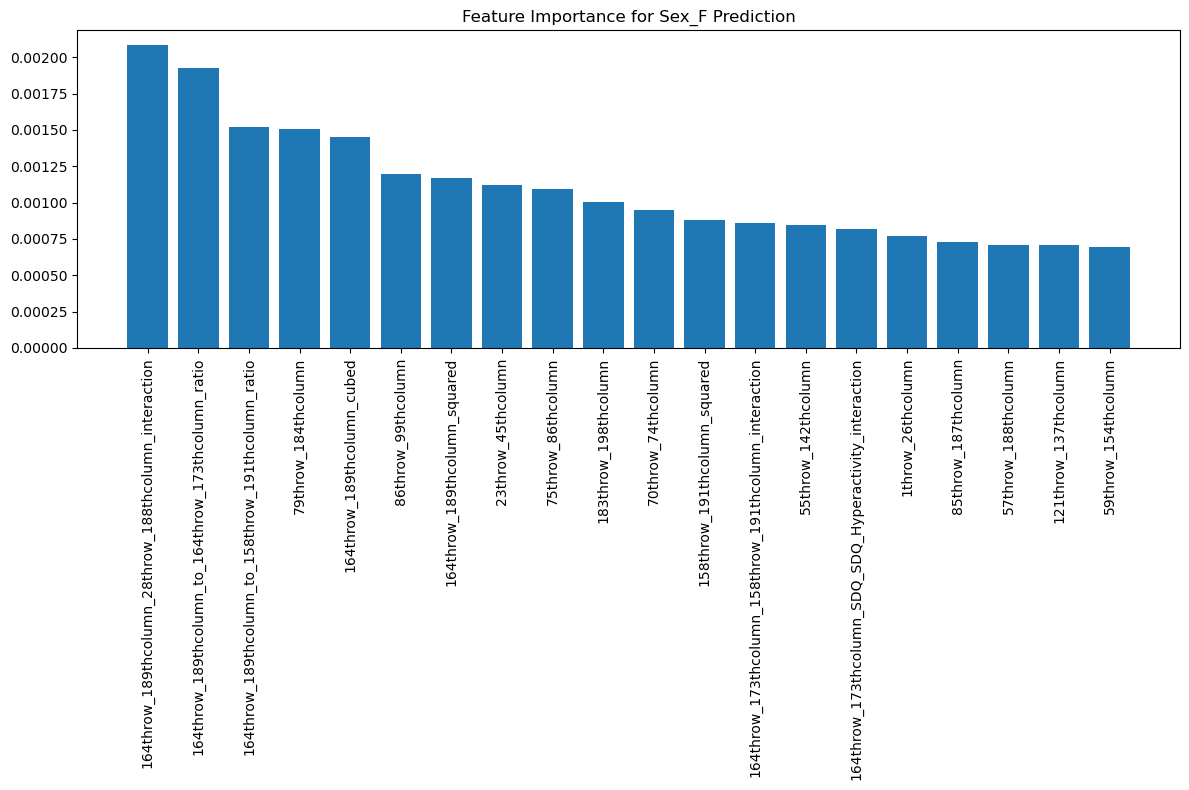

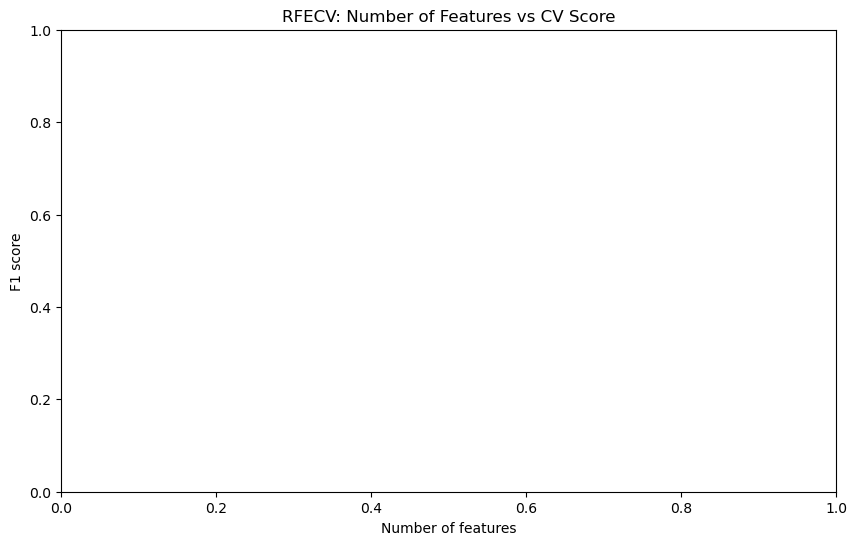

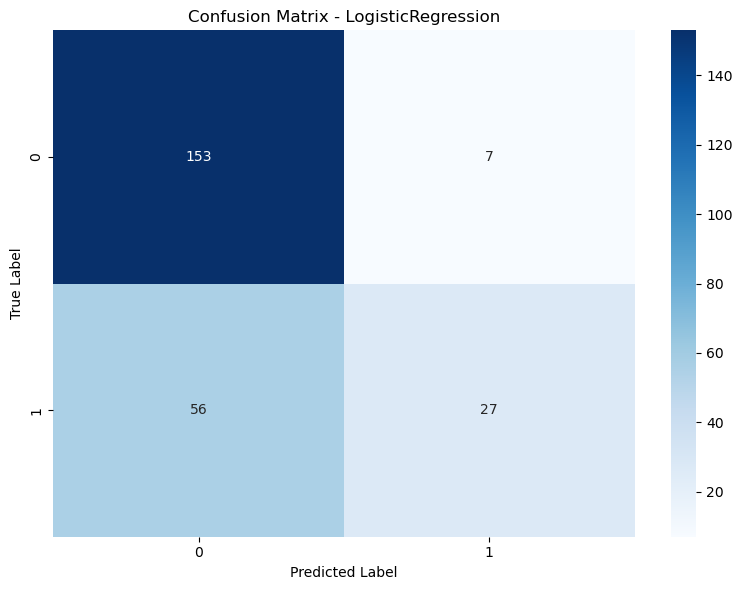

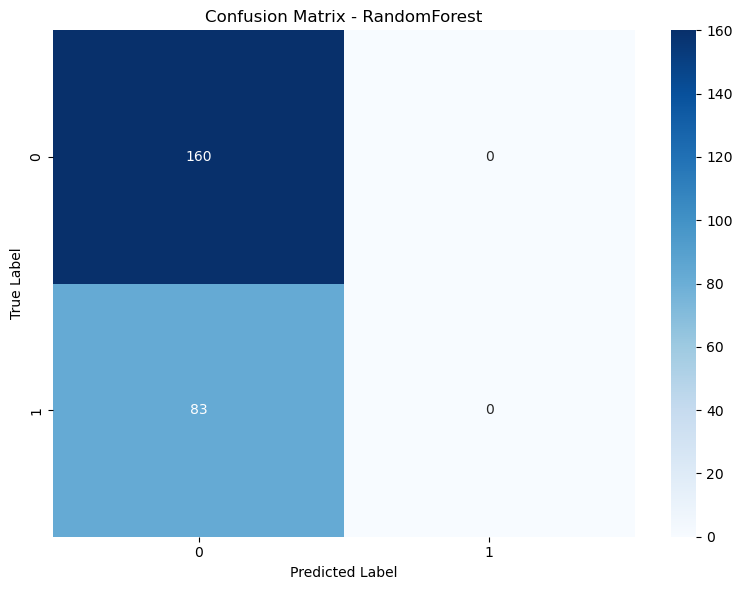

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Assuming train_df_50 is already loaded

# 1. First, let's explore the relationship between features and Sex_F
def analyze_sex_f_relationships(df):
    """Analyzes relationships between features and Sex_F"""
    sex_target = df['Sex_F']
    
    # Get feature columns (excluding ADHD_Outcome, Sex_F, and any ID columns)
    feature_cols = [col for col in df.columns if col not in ["ADHD_Outcome", "Sex_F", "ID", "participant_id"]]
    
    # Calculate correlation with Sex_F
    corr_with_sex = {}
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            corr = df[col].corr(pd.to_numeric(sex_target, errors='coerce'))
            if not np.isnan(corr):
                corr_with_sex[col] = corr
    
    # Sort by absolute correlation
    sorted_corr = {k: v for k, v in sorted(corr_with_sex.items(), key=lambda item: abs(item[1]), reverse=True)}
    
    # Print top correlations
    print("Top features correlated with Sex_F:")
    for i, (feature, corr) in enumerate(sorted_corr.items()):
        if i < 15:  # Show top 15
            print(f"{feature}: {corr:.4f}")
    
    return sorted_corr, feature_cols

# 2. Feature Engineering Functions
def create_engineered_features(df, feature_cols):
    """Creates various engineered features to improve Sex_F prediction"""
    # Make a copy to avoid modifying the original dataframe
    df_engineered = df.copy()
    
    # Get only numeric features for transformations
    numeric_features = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df[col])]
    
    # 1. Create polynomial features for top correlated features
    # Get the top 5 correlated features (assuming sorted_corr is available)
    top_features = list(sorted_corr.keys())[:5]
    for feature in top_features:
        if feature in numeric_features:
            # Square and cube features
            df_engineered[f"{feature}_squared"] = df[feature] ** 2
            df_engineered[f"{feature}_cubed"] = df[feature] ** 3
    
    # 2. Create interaction terms between highly correlated features
    for i, feat1 in enumerate(top_features[:4]):
        for feat2 in top_features[i+1:]:
            if feat1 in numeric_features and feat2 in numeric_features:
                df_engineered[f"{feat1}_{feat2}_interaction"] = df[feat1] * df[feat2]
    
    # 3. Create ratio features for pairs of promising features
    for i, feat1 in enumerate(top_features[:3]):
        for feat2 in top_features[i+1:4]:
            if feat1 in numeric_features and feat2 in numeric_features:
                # Avoid division by zero
                denominator = df[feat2].replace(0, np.nan)
                df_engineered[f"{feat1}_to_{feat2}_ratio"] = (df[feat1] / denominator).fillna(0)
    
    # 4. Apply non-linear transformations to capture non-linear relationships
    for feature in numeric_features[:10]:  # Apply to top 10 numeric features
        # Log transformation (handling negative values)
        min_val = df[feature].min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            df_engineered[f"{feature}_log"] = np.log(df[feature] + shift)
        else:
            df_engineered[f"{feature}_log"] = np.log(df[feature])
        
        # Sigmoid transformation to normalize between 0 and 1
        df_engineered[f"{feature}_sigmoid"] = 1 / (1 + np.exp(-df[feature]))
    
    # 5. Create binned versions of continuous features to capture threshold effects
    for feature in numeric_features[:5]:  # Top 5 features
        df_engineered[f"{feature}_binned"] = pd.qcut(df[feature], q=5, duplicates='drop', labels=False)
    
    # 6. Calculate distances from feature medians by sex group
    # First, get median values for each sex group
    medians_by_sex = {}
    sex_groups = df['Sex_F'].unique()
    
    for sex_val in sex_groups:
        subset = df[df['Sex_F'] == sex_val]
        medians = {}
        for feature in numeric_features[:10]:  # Top 10 features
            medians[feature] = subset[feature].median()
        medians_by_sex[sex_val] = medians
    
    # Calculate distances from the medians
    for sex_val in sex_groups:
        for feature in numeric_features[:10]:
            median = medians_by_sex[sex_val][feature]
            df_engineered[f"{feature}_dist_from_{sex_val}_median"] = abs(df[feature] - median)
    
    # 7. Create statistical aggregations
    # Calculate rolling statistics on sorted data
    for feature in numeric_features[:5]:
        sorted_idx = df[feature].sort_values().index
        values = df.loc[sorted_idx, feature].values
        
        # Calculate rolling mean with window=5
        rolling_mean = pd.Series(index=sorted_idx, data=values).rolling(window=5, min_periods=1).mean().values
        df_engineered.loc[sorted_idx, f"{feature}_rolling_mean"] = rolling_mean
        
        # Calculate rolling std with window=5
        rolling_std = pd.Series(index=sorted_idx, data=values).rolling(window=5, min_periods=1).std().fillna(0).values
        df_engineered.loc[sorted_idx, f"{feature}_rolling_std"] = rolling_std
    
    # 8. Create feature clusters using K-means to capture feature groups
    from sklearn.cluster import KMeans
    
    # Select a subset of important numeric features
    subset_features = numeric_features[:10]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    feature_matrix = imputer.fit_transform(df[subset_features])
    
    # Scale features
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(feature_matrix_scaled)
    
    # Add cluster as a feature
    df_engineered['feature_cluster'] = clusters
    
    # 9. Apply non-linear transformations to capture complex distributions
    pt = PowerTransformer(method='yeo-johnson')
    qt = QuantileTransformer(output_distribution='normal')
    
    for feature in numeric_features[:5]:
        # Reshape for scikit-learn
        values = df[feature].values.reshape(-1, 1)
        
        # Power transform
        try:
            pt_values = pt.fit_transform(values).flatten()
            df_engineered[f"{feature}_power_transform"] = pt_values
        except:
            pass
        
        # Quantile transform
        try:
            qt_values = qt.fit_transform(values).flatten()
            df_engineered[f"{feature}_quantile_transform"] = qt_values
        except:
            pass
    
    # 10. Create PCA components to capture variance in the data
    pca = PCA(n_components=min(5, len(numeric_features)))
    try:
        pca_features = pca.fit_transform(imputer.fit_transform(df[numeric_features]))
        
        # Add PCA components as features
        for i in range(pca_features.shape[1]):
            df_engineered[f"pca_component_{i+1}"] = pca_features[:, i]
    except:
        print("Could not perform PCA, possibly due to missing values or other issues.")
    
    return df_engineered

# 3. Feature Selection Functions
def select_best_features_for_sex_f(df_engineered, original_feature_cols):
    """Selects the best features for Sex_F prediction"""
    target = df_engineered['Sex_F']
    
    # Get all feature columns including engineered ones
    all_feature_cols = [col for col in df_engineered.columns if col not in ["ADHD_Outcome", "Sex_F", "ID", "participant_id"]]
    
    # Impute missing values
    X = df_engineered[all_feature_cols]
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # First, use a Random Forest to gauge feature importance
    print("\nFeature selection using Random Forest importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_imputed, target)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("Feature ranking:")
    for f in range(min(20, X_imputed.shape[1])):  # Print top 20 features
        print(f"{f+1}. {X_imputed.columns[indices[f]]} ({importances[indices[f]]:.4f})")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance for Sex_F Prediction")
    plt.bar(range(min(20, X_imputed.shape[1])), importances[indices[:20]], align="center")
    plt.xticks(range(min(20, X_imputed.shape[1])), [X_imputed.columns[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.savefig('sex_f_feature_importance.png')
    
    # Use SelectFromModel to select the most important features
    selector = SelectFromModel(estimator=rf, threshold='median')
    X_important = selector.fit_transform(X_imputed, target)
    selected_features = X_imputed.columns[selector.get_support()]
    
    print(f"\nSelected {len(selected_features)} features using Random Forest importance.")
    
    # Also try Recursive Feature Elimination with Cross Validation
    print("\nPerforming Recursive Feature Elimination with Cross Validation...")
    try:
        # This can be computationally expensive, so we'll use a smaller subset if there are many features
        if X_imputed.shape[1] > 50:
            # First filter using RF importance
            X_subset = X_imputed.iloc[:, indices[:50]]  # Top 50 features by importance
        else:
            X_subset = X_imputed
            
        rfecv = RFECV(
            estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
            step=1,
            cv=StratifiedKFold(5),
            scoring='f1_weighted',
            min_features_to_select=5
        )
        
        rfecv.fit(X_subset, target)
        
        print(f"Optimal number of features: {rfecv.n_features_}")
        if X_imputed.shape[1] > 50:
            rfecv_selected = X_subset.columns[rfecv.support_]
        else:
            rfecv_selected = X_imputed.columns[rfecv.support_]
            
        print("Features selected by RFECV:")
        for feature in rfecv_selected:
            print(f"- {feature}")
            
        # Plot CV scores
        plt.figure(figsize=(10, 6))
        plt.title("RFECV: Number of Features vs CV Score")
        plt.xlabel("Number of features")
        plt.ylabel("F1 score")
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        plt.tight_layout()
        plt.savefig('sex_f_rfecv_scores.png')
    except Exception as e:
        print(f"RFECV failed: {e}")
        rfecv_selected = selected_features  # Fall back to SelectFromModel results
    
    # Combine the features selected by both methods
    final_features = list(set(selected_features) | set(rfecv_selected))
    print(f"\nFinal set of {len(final_features)} features:")
    for feature in final_features:
        print(f"- {feature}")
    
    # Evaluate how many engineered features were selected
    original_count = sum(1 for feat in final_features if feat in original_feature_cols)
    engineered_count = len(final_features) - original_count
    print(f"\nSelected {original_count} original features and {engineered_count} engineered features.")
    
    return final_features

# 4. Model Evaluation Function
def evaluate_sex_f_prediction(df_engineered, selected_features):
    """Evaluates the performance of ML models on selected features for Sex_F prediction"""
    target = df_engineered['Sex_F']
    
    # Split the data
    X = df_engineered[selected_features]
    y = target
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)
    
    # Define models to evaluate
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
    }
    
    # Evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
        cv_f1 = cv_scores.mean()
        
        # Test set prediction
        y_pred = model.predict(X_test)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store results
        results[name] = {
            'cv_f1': cv_f1,
            'test_f1': test_f1,
            'model': model
        }
        
        # Print results
        print(f"Cross-validation F1 score: {cv_f1:.4f}")
        print(f"Test set F1 score: {test_f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'sex_f_confusion_matrix_{name}.png')
    
    # Find best model
    best_model_name = max(results, key=lambda x: results[x]['test_f1'])
    print(f"\nBest model: {best_model_name} with F1 score: {results[best_model_name]['test_f1']:.4f}")
    
    return results

# 5. Run the full feature engineering and evaluation process
print("Starting Sex_F feature engineering and model evaluation...\n")

# Analyze relationships
sorted_corr, original_feature_cols = analyze_sex_f_relationships(train_df_50)

# Create engineered features
print("\nGenerating engineered features...")
df_engineered = create_engineered_features(train_df_50, original_feature_cols)
print(f"Created {df_engineered.shape[1] - train_df_50.shape[1]} new features.")

# Select best features
selected_features = select_best_features_for_sex_f(df_engineered, original_feature_cols)

# Evaluate models
results = evaluate_sex_f_prediction(df_engineered, selected_features)

# Apply to test set and generate predictions
# Assuming test_df is available, apply same transformations and predict
def predict_on_test_set(test_df, df_engineered, selected_features, results):
    """Applies feature engineering to test set and generates predictions"""
    print("\nApplying feature engineering to test set...")
    
    # Apply same feature engineering to test set
    test_engineered = create_engineered_features(test_df, original_feature_cols)
    
    # Get the best model
    best_model_name = max(results, key=lambda x: results[x]['test_f1'])
    best_model = results[best_model_name]['model']
    
    # Prepare features
    X_test = test_engineered[selected_features]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)
    
    # Generate predictions
    sex_f_predictions = best_model.predict(X_test_imputed)
    sex_f_probas = best_model.predict_proba(X_test_imputed)
    
    # Create prediction DataFrame
    predictions_df = pd.DataFrame({
        'participant_id': test_df['participant_id'] if 'participant_id' in test_df.columns else test_df.index,
        'Sex_F_Prediction': sex_f_predictions
    })
    
    # Add probability columns if it's a binary classification
    if sex_f_probas.shape[1] == 2:
        predictions_df['Sex_F_Probability'] = sex_f_probas[:, 1]
    
    # Save predictions
    predictions_df.to_csv('sex_f_predictions_with_engineered_features.csv', index=False)
    print("Predictions saved to 'sex_f_predictions_with_engineered_features.csv'")
    
    return predictions_df, best_model_name, results[best_model_name]['test_f1']

# Apply to test set if available
try:
    predictions_df, best_model_name, best_f1 = predict_on_test_set(test_df, df_engineered, selected_features, results)
    print(f"\nFeature Engineering Summary:")
    print(f"- Best model: {best_model_name}")
    print(f"- F1 Score: {best_f1:.4f}")
    print(f"- Features used: {len(selected_features)}")
    print(f"  - Original features: {sum(1 for feat in selected_features if feat in original_feature_cols)}")
    print(f"  - Engineered features: {sum(1 for feat in selected_features if feat not in original_feature_cols)}")
except:
    print("\nTest set not available. Skipping prediction generation.")
    print("\nFeature Engineering Summary:")
    best_model_name = max(results, key=lambda x: results[x]['test_f1'])
    best_f1 = results[best_model_name]['test_f1']
    print(f"- Best model: {best_model_name}")
    print(f"- F1 Score: {best_f1:.4f}")
    print(f"- Features used: {len(selected_features)}")
    print(f"  - Original features: {sum(1 for feat in selected_features if feat in original_feature_cols)}")
    print(f"  - Engineered features: {sum(1 for feat in selected_features if feat not in original_feature_cols)}")